In [40]:
import networkx as nx
import os
import re
import numpy as np
import pickle
import random
import math
import matplotlib.pyplot as plt


In [41]:
# load graph:
S = pickle.load(open("graph.pkl", "rb"))
print(f"Number of nodes: {S.number_of_nodes()}")
print(f"Number of edges: {S.number_of_edges()}")

n_nodes = S.number_of_nodes()
n_edges = S.number_of_edges()

Number of nodes: 1366
Number of edges: 10850


In [42]:
# Turn to undirected graph
S = S.to_undirected()

# Comparison to Barabasi-Albert model graph

In [43]:
def grow_Barabasi_Albert_graph(n=5000, E=None):
    if E is None:
        raise ValueError("Total number of edges E must be specified.")
    if n < 2:
        raise ValueError("Number of nodes n must be at least 2.")
    
    # Function to approximate m from n and E
    def approximate_m(n, E):
        best_m = None
        min_diff = float('inf')
        for m in range(1, n):
            total_edges = m * n - (m * (m + 1)) // 2
            diff = abs(total_edges - E)
            if diff < min_diff:
                min_diff = diff
                best_m = m
            if diff == 0:
                break
        return best_m
    
    m = approximate_m(n, E)
    print(f"Using m = {m} to approximate E = {E}")
    
    # Initialize the graph with a complete graph of m nodes
    F_BA = nx.complete_graph(m)
    
    # Function to get the degree list for preferential attachment
    def get_degree_list(G):
        degree_list = []
        for node in G.nodes:
            degree_list.extend([node] * G.degree[node])
        return degree_list

    # Function to add a new node connected to m existing nodes preferentially
    def add_node_proportional_to_degree(G, new_node, m):
        degree_list = get_degree_list(G)
        targets = set()
        while len(targets) < m:
            target_node = random.choice(degree_list)
            targets.add(target_node)
        for target_node in targets:
            G.add_edge(new_node, target_node)
    
    # Add the remaining n - m nodes
    for new_node in range(m, n):
        add_node_proportional_to_degree(F_BA, new_node, m)
    
    return F_BA

# Example usage
random.seed(42)
F_BA = grow_Barabasi_Albert_graph(n=n_nodes, E=n_edges)


Using m = 8 to approximate E = 10850


In [44]:
print(f"Number of nodes: {F_BA.number_of_nodes()}")
print(f"Number of edges: {F_BA.number_of_edges()}")

Number of nodes: 1366
Number of edges: 10892


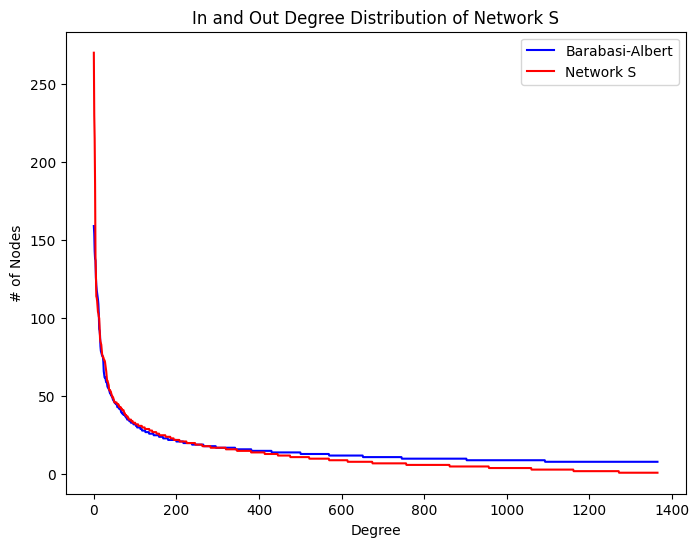

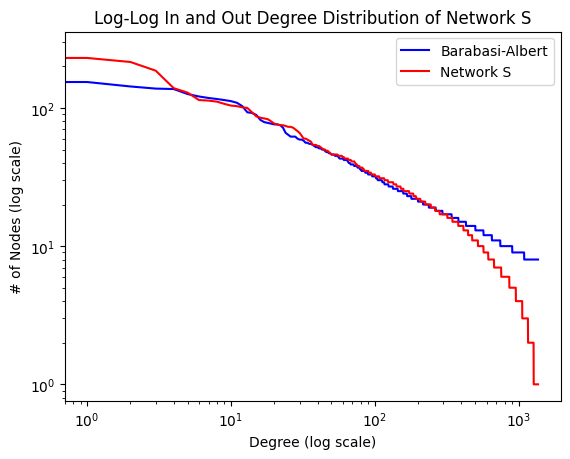

In [45]:
# Plotting the degree distributions
degree_sequence_F_BA = sorted([d for n, d in F_BA.degree()], reverse=True)
degree_sequence_S = sorted([d for n, d in S.degree()], reverse=True)

## Plot setup
plt.figure(figsize=(8, 6))

## Plotting the degree distribution as a linear plot
plt.plot(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.plot(degree_sequence_S, 'r-', label='Network S')

plt.xlabel('Degree')
plt.ylabel('# of Nodes')
plt.title('In and Out Degree Distribution of Network S')
plt.legend()
plt.show()


## Plotting the degree distribution as a log-log plot
plt.loglog(degree_sequence_F_BA, 'b-', label='Barabasi-Albert')
plt.loglog(degree_sequence_S, 'r-', label='Network S')

plt.xlabel('Degree (log scale)')
plt.ylabel('# of Nodes (log scale)')
plt.title('Log-Log In and Out Degree Distribution of Network S')
plt.legend()
plt.show()

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

def compute_network_metrics(graph):
    """Computes and returns key metrics for a graph."""
    metrics = {}
    
    # Degree Distribution
    degrees = [d for _, d in graph.degree()]
    metrics['degree_histogram'] = nx.degree_histogram(graph)
    
    # Clustering Coefficient
    metrics['global_clustering'] = nx.transitivity(graph)
    metrics['average_clustering'] = nx.average_clustering(graph)
    
    # Assortativity
    metrics['assortativity'] = nx.degree_assortativity_coefficient(graph)
    
    # Connected Components
    components = list(nx.connected_components(graph))
    metrics['num_connected_components'] = len(components)
    metrics['largest_component_size'] = len(max(components, key=len))
    
    # Shortest Path Lengths (only for the largest connected component)
    largest_component = graph.subgraph(max(components, key=len)).copy()
    metrics['average_shortest_path'] = nx.average_shortest_path_length(largest_component)
    metrics['diameter'] = nx.diameter(largest_component)
    
    # Degree Centrality
    metrics['degree_centrality'] = nx.degree_centrality(graph)
    
    return metrics

# Compute metrics for both graphs
wiki_metrics = compute_network_metrics(S)
ba_metrics = compute_network_metrics(F_BA)

# Compare metrics
print("Philosopher Wikipedia Graph Metrics:")
for key, value in wiki_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value}")
        
print("\nBarabási-Albert Graph Metrics:")
for key, value in ba_metrics.items():
    if key not in ['degree_histogram', 'degree_centrality']:
        print(f"{key}: {value}")


Philosopher Wikipedia Graph Metrics:
global_clustering: 0.11652067966280295
average_clustering: 0.2801646258482919
assortativity: -0.1068392379980094
num_connected_components: 1
largest_component_size: 1366
average_shortest_path: 3.0391807314208488
diameter: 8

Barabási-Albert Graph Metrics:
global_clustering: 0.03909360479617193
average_clustering: 0.04361157394576715
assortativity: -0.01900335034757547
num_connected_components: 1
largest_component_size: 1366
average_shortest_path: 2.747196970915858
diameter: 4


# Model Fitting

In [47]:
import pickle
import numpy as np
import networkx as nx
from scipy.stats import poisson, expon, lognorm
import powerlaw
import warnings

# Ignore warnings from powerlaw package
warnings.filterwarnings("ignore")

# Step 2: Extract the degree sequence
degrees = np.array([d for n, d in S.degree()])
print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")

# Step 3: Fit candidate distributions using MLE

# 3a. Poisson Distribution
lambda_poisson = np.mean(degrees)
log_likelihood_poisson = np.sum(poisson.logpmf(degrees, lambda_poisson))

# 3b. Exponential Distribution (continuous approximation)
params_exp = expon.fit(degrees, floc=0)  # Fix loc=0
lambda_exp = 1 / params_exp[1]  # Scale parameter is 1/lambda
log_likelihood_exp = np.sum(expon.logpdf(degrees, *params_exp))

# 3c. Log-Normal Distribution
params_lognorm = lognorm.fit(degrees[degrees > 0], floc=0)  # Exclude zeros
sigma_lognorm, loc_lognorm, scale_lognorm = params_lognorm
log_likelihood_lognorm = np.sum(lognorm.logpdf(degrees[degrees > 0], *params_lognorm))

# 3d. Power-Law Distribution
fit = powerlaw.Fit(degrees, xmin=1)
alpha_powerlaw = fit.power_law.alpha
xmin_powerlaw = fit.power_law.xmin
log_likelihood_powerlaw = fit.power_law.loglikelihoods(degrees).sum()

# Step 4: Compute AIC and BIC for each model
n = len(degrees)

# Poisson
k_poisson = 1  # lambda
AIC_poisson = 2 * k_poisson - 2 * log_likelihood_poisson
BIC_poisson = k_poisson * np.log(n) - 2 * log_likelihood_poisson

# Exponential
k_exp = 1  # lambda
AIC_exp = 2 * k_exp - 2 * log_likelihood_exp
BIC_exp = k_exp * np.log(n) - 2 * log_likelihood_exp

# Log-Normal
n_lognorm = len(degrees[degrees > 0])
k_lognorm = 2  # sigma and scale
AIC_lognorm = 2 * k_lognorm - 2 * log_likelihood_lognorm
BIC_lognorm = k_lognorm * np.log(n_lognorm) - 2 * log_likelihood_lognorm

# Power-Law
n_powerlaw = len(degrees[degrees >= xmin_powerlaw])
k_powerlaw = 2  # alpha and xmin
AIC_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw
BIC_powerlaw = k_powerlaw * np.log(n_powerlaw) - 2 * log_likelihood_powerlaw

# Step 5: Select the best-fitting model based on AIC and BIC
AICs = {
    'Poisson': AIC_poisson,
    'Exponential': AIC_exp,
    'Log-Normal': AIC_lognorm,
    'Power-Law': AIC_powerlaw
}

BICs = {
    'Poisson': BIC_poisson,
    'Exponential': BIC_exp,
    'Log-Normal': BIC_lognorm,
    'Power-Law': BIC_powerlaw
}

best_fit_aic = min(AICs, key=AICs.get)
best_fit_bic = min(BICs, key=BICs.get)

# Output results
print("\nModel fitting results:")
print("-----------------------")
print("Log-Likelihoods:")
print(f"Poisson: {log_likelihood_poisson}")
print(f"Exponential: {log_likelihood_exp}")
print(f"Log-Normal: {log_likelihood_lognorm}")
print(f"Power-Law: {log_likelihood_powerlaw}\n")

print("AIC values:")
for dist, aic in AICs.items():
    print(f"{dist}: {aic}")
print(f"Best fit according to AIC: {best_fit_aic}\n")

print("BIC values:")
for dist, bic in BICs.items():
    print(f"{dist}: {bic}")
print(f"Best fit according to BIC: {best_fit_bic}\n")

print("Estimated parameters:")
print("---------------------")
print(f"Poisson lambda: {lambda_poisson}")
print(f"Exponential lambda: {lambda_exp}")
print(f"Log-Normal sigma: {sigma_lognorm}, scale: {scale_lognorm}")
print(f"Power-Law alpha: {alpha_powerlaw}, xmin: {xmin_powerlaw}")


Minimum degree: 1
Maximum degree: 270

Model fitting results:
-----------------------
Log-Likelihoods:
Poisson: -12886.754131010563
Exponential: -4891.394126109269
Log-Normal: -4762.912073388454
Power-Law: -5100.349472767519

AIC values:
Poisson: 25775.508262021125
Exponential: 9784.788252218537
Log-Normal: 9529.824146776908
Power-Law: 10204.698945535038
Best fit according to AIC: Log-Normal

BIC values:
Poisson: 25780.727904061256
Exponential: 9790.007894258668
Log-Normal: 9540.263430857169
Power-Law: 10215.138229615299
Best fit according to BIC: Log-Normal

Estimated parameters:
---------------------
Poisson lambda: 13.207906295754027
Exponential lambda: 0.07571222702582862
Log-Normal sigma: 1.041505831824949, scale: 7.592435009787176
Power-Law alpha: 1.4933028324187014, xmin: 1.0


In [48]:
# Step 6: Create Log-Log Plots for Each Model

# Function to plot empirical data and fitted model on log-log scale
def plot_degree_distribution_loglog(degrees, model_name, fitted_params):
    plt.figure(figsize=(8, 6))
    
    # Empirical degree distribution
    degree_counts = np.bincount(degrees)
    degrees_unique = np.nonzero(degree_counts)[0]
    counts = degree_counts[degrees_unique]
    prob = counts / counts.sum()
    
    plt.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
    
    # Generate degrees for plotting fitted model
    x = np.arange(degrees_unique.min(), degrees_unique.max()+1)
    
    if model_name == 'Poisson':
        pmf = poisson.pmf(x, fitted_params['lambda'])
        plt.plot(x, pmf, 'r-', label='Poisson Fit')
    elif model_name == 'Exponential':
        # For discrete plotting, use the CDF to approximate
        # Alternatively, treat as continuous
        pdf = expon.pdf(x, scale=fitted_params['scale'])
        plt.plot(x, pdf, 'g-', label='Exponential Fit')
    elif model_name == 'Log-Normal':
        # Avoid zero by starting from 1
        pdf = lognorm.pdf(x, fitted_params['sigma'], loc=fitted_params['loc'], scale=fitted_params['scale'])
        plt.plot(x, pdf, 'm-', label='Log-Normal Fit')
    elif model_name == 'Power-Law':
        # Power-law PDF: C * x^{-alpha}
        pdf = (x ** (-fitted_params['alpha']))
        # Normalize the PDF over the range xmin to max(x)
        pdf = pdf / pdf.sum()
        plt.plot(x, pdf, 'k-', label='Power-Law Fit')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Probability (log scale)')
    plt.title(f'Degree Distribution with {model_name} Fit')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Prepare fitted parameters for each model
fitted_models = {
    'Poisson': {'lambda': lambda_poisson},
    'Exponential': {'scale': params_exp[1]},  # scale = 1/lambda
    'Log-Normal': {'sigma': sigma_lognorm, 'loc': loc_lognorm, 'scale': scale_lognorm},
    'Power-Law': {'alpha': alpha_powerlaw, 'xmin': xmin_powerlaw}
}

# # Create separate plots for each model
# for model in ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']:
#     plot_degree_distribution_loglog(degrees, model, fitted_models[model])


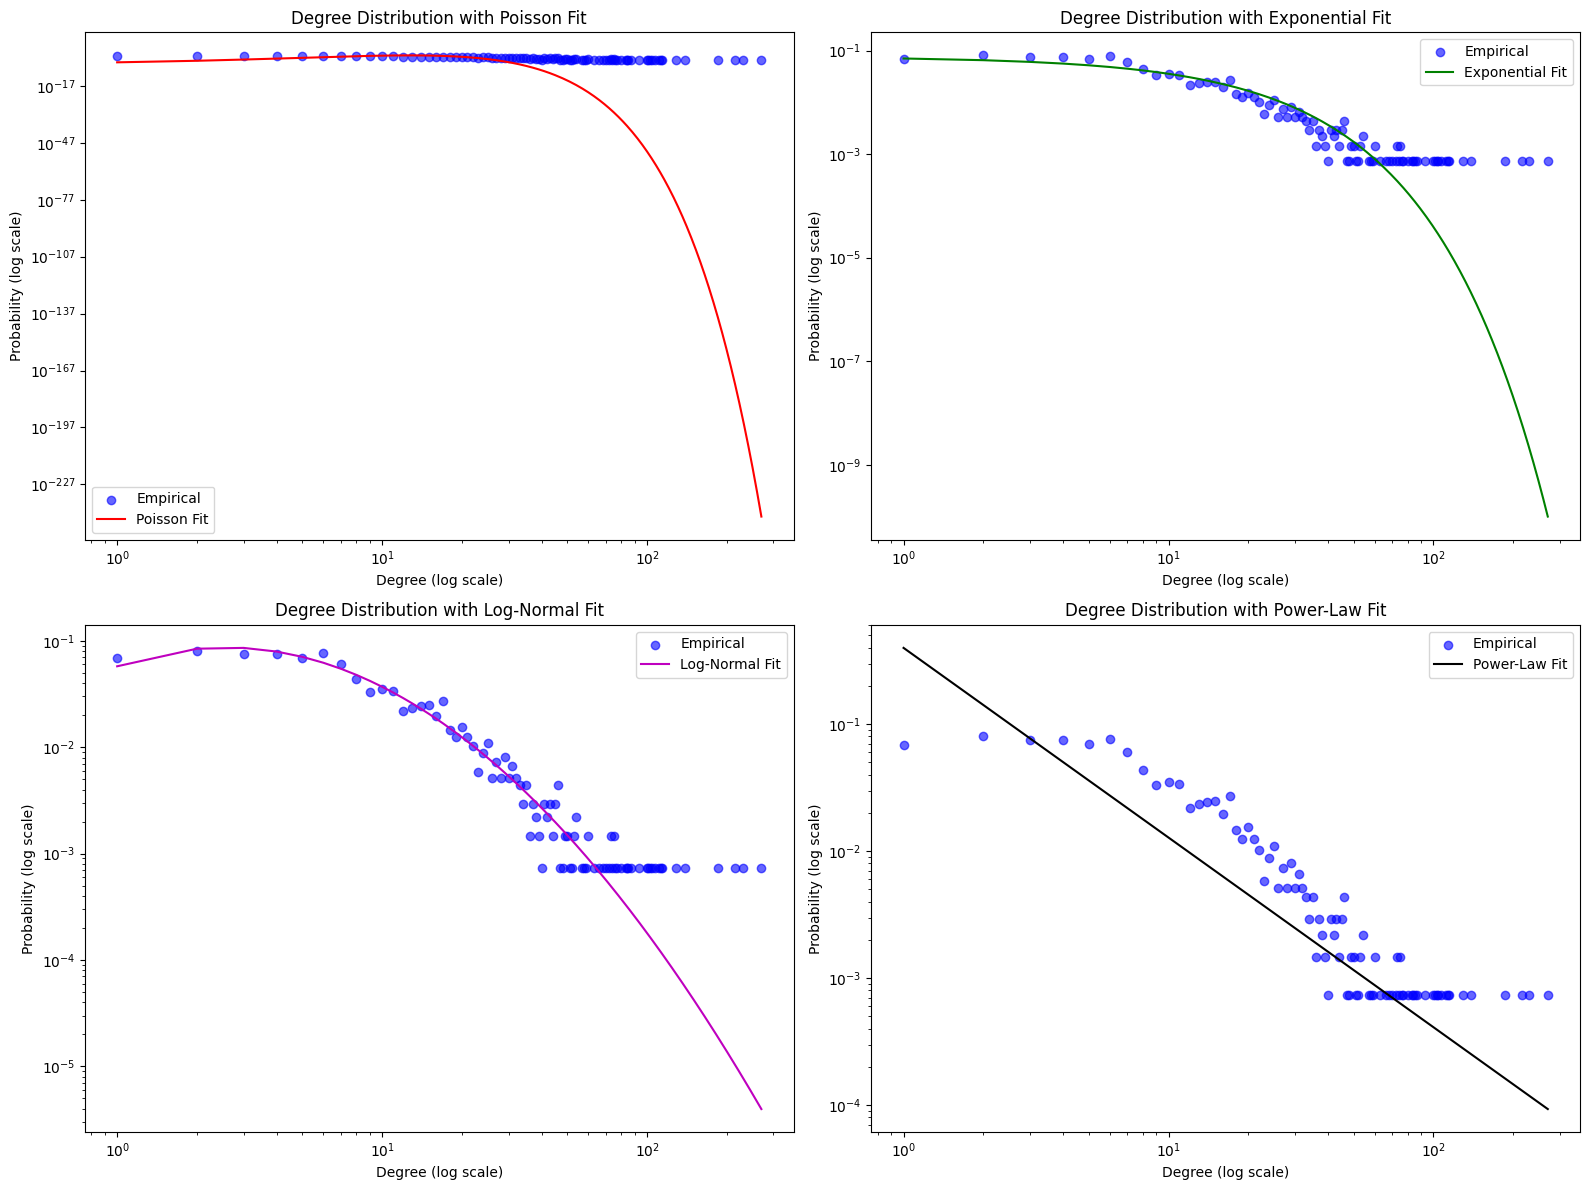

In [49]:
def plot_all_models_loglog(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max()+1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Degree (log scale)')
        ax.set_ylabel('Probability (log scale)')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_all_models_loglog(degrees, fitted_models)

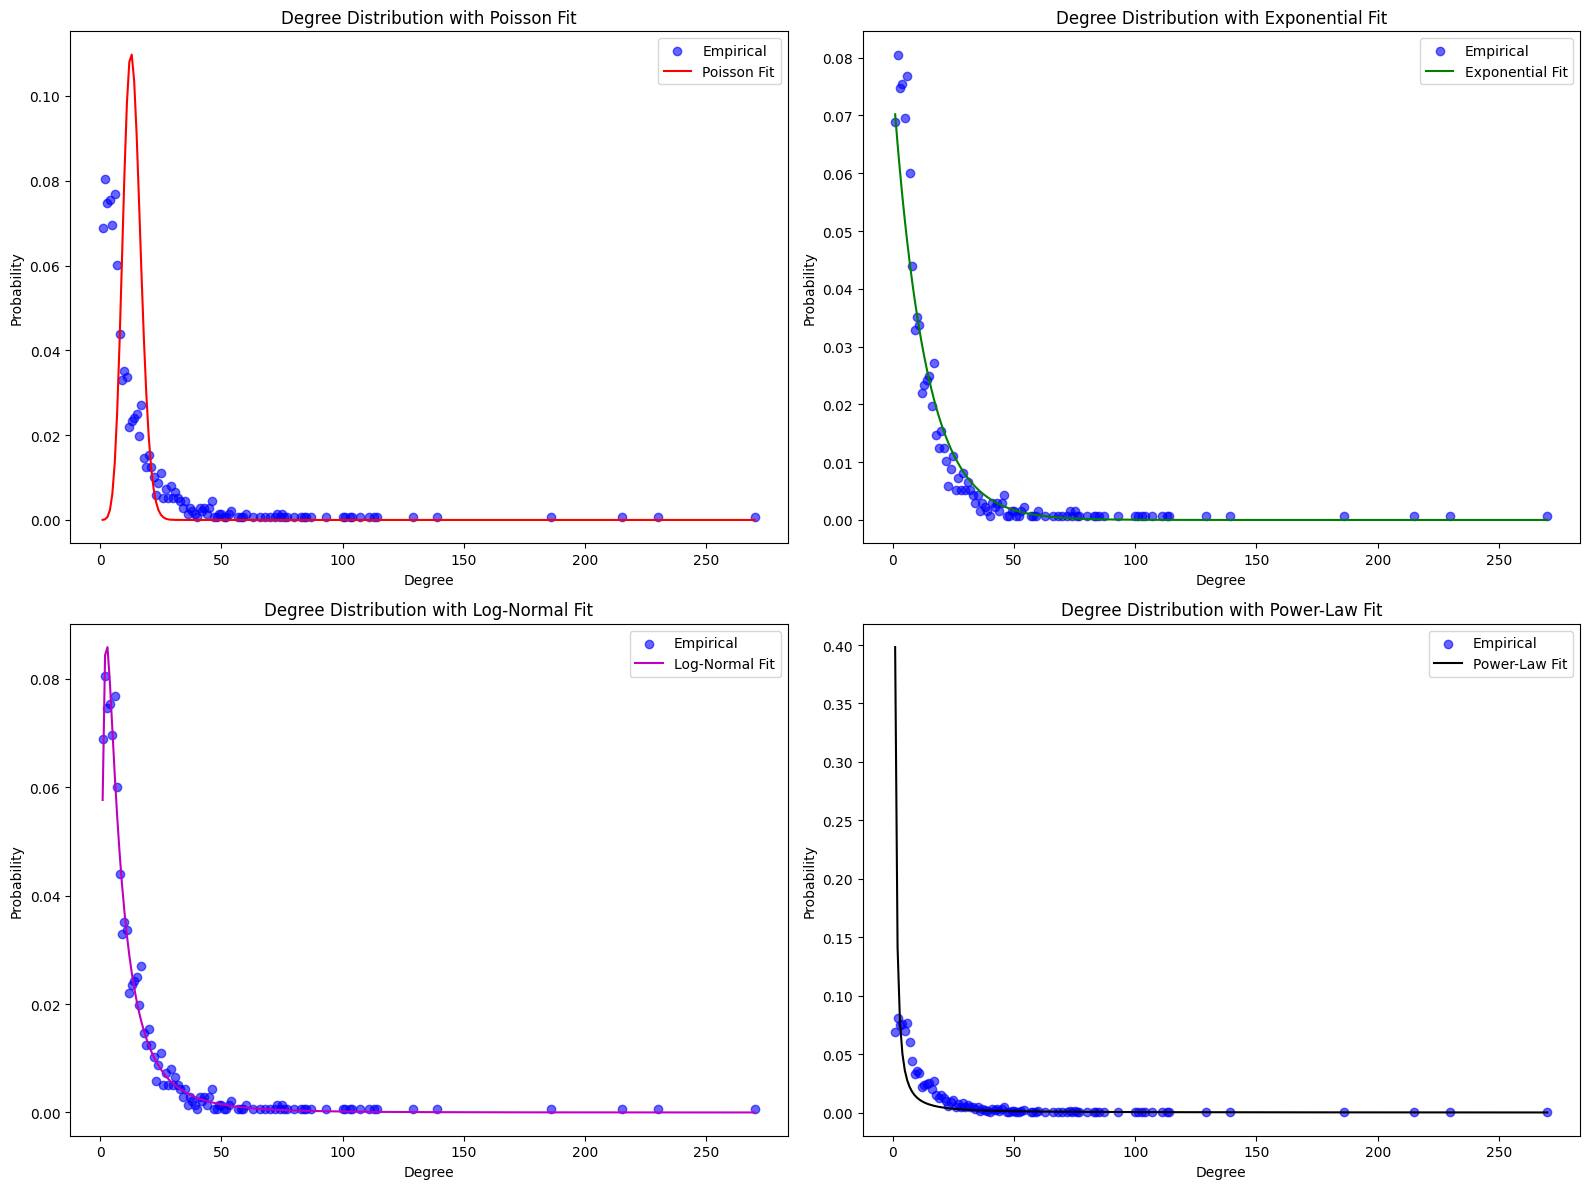

In [50]:
def plot_all_models_linear(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max() + 1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xlabel('Degree')
        ax.set_ylabel('Probability')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Call the new function
plot_all_models_linear(degrees, fitted_models)
